<a href="https://colab.research.google.com/github/likeshd/time_series_models_libraries/blob/main/Metro_Traffic_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime
from datetime import date
import random
from sklearn.metrics import mean_squared_error, mean_absolute_error


import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
# from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import gc

import warnings
warnings.filterwarnings('ignore')


In [2]:
data = pd.read_csv('/content/Metro_Interstate_Traffic_Volume.csv', infer_datetime_format=True)
data.head(5)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              61 non-null     object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [3]:
data['date_time'] =  pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   holiday              61 non-null     object        
 1   temp                 48204 non-null  float64       
 2   rain_1h              48204 non-null  float64       
 3   snow_1h              48204 non-null  float64       
 4   clouds_all           48204 non-null  int64         
 5   weather_main         48204 non-null  object        
 6   weather_description  48204 non-null  object        
 7   date_time            48204 non-null  datetime64[ns]
 8   traffic_volume       48204 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 3.3+ MB


In [4]:
data.describe(include= "all")

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
count,61,48204.000000,48204.000000,48204.000000,48204.000000,48204,48204,48204,48204.000000
unique,11,NaN,NaN,NaN,NaN,11,38,NaN,NaN
top,Labor Day,NaN,NaN,NaN,NaN,Clouds,sky is clear,NaN,NaN
freq,7,NaN,NaN,NaN,NaN,15164,11665,NaN,NaN
mean,NaN,281.205870,0.334264,0.000222,49.362231,NaN,NaN,2016-01-05 10:46:16.773711616,3259.818355
min,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,2012-10-02 09:00:00,0.000000
25%,NaN,272.160000,0.000000,0.000000,1.000000,NaN,NaN,2014-02-06 11:45:00,1193.000000
50%,NaN,282.450000,0.000000,0.000000,64.000000,NaN,NaN,2016-06-11 03:30:00,3380.000000
75%,NaN,291.806000,0.000000,0.000000,90.000000,NaN,NaN,2017-08-11 06:00:00,4933.000000
max,NaN,310.070000,9831.300000,0.510000,100.000000,NaN,NaN,2018-09-30 23:00:00,7280.000000


In [5]:
data = data.set_index(pd.DatetimeIndex(data['date_time'])).rename(columns={"date_time": "ds"}).drop_duplicates(subset=['ds'])
data.head(5)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,ds,traffic_volume
date_time,,,,,,,,,
2012-10-02 09:00:00,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
2012-10-02 10:00:00,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2012-10-02 11:00:00,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
2012-10-02 12:00:00,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
2012-10-02 13:00:00,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [6]:
ts = data['2018-08-30':'2018-09-29']
ts.head(5)
ts.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2018-08-30 00:00:00 to 2018-09-29 23:00:00
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   holiday              1 non-null      object        
 1   temp                 744 non-null    float64       
 2   rain_1h              744 non-null    float64       
 3   snow_1h              744 non-null    float64       
 4   clouds_all           744 non-null    int64         
 5   weather_main         744 non-null    object        
 6   weather_description  744 non-null    object        
 7   ds                   744 non-null    datetime64[ns]
 8   traffic_volume       744 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 58.1+ KB


In [9]:
ts1= ts.replace(np.nan, "None")
# df = df.replace(np.nan, None)
ts1.head(5)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,ds,traffic_volume
date_time,,,,,,,,,
2018-08-30 00:00:00,None,286.24,0.25,0.0,1,Rain,light rain,2018-08-30 00:00:00,670
2018-08-30 01:00:00,None,285.53,0.25,0.0,1,Rain,light rain,2018-08-30 01:00:00,456
2018-08-30 02:00:00,None,285.35,0.25,0.0,1,Rain,light rain,2018-08-30 02:00:00,326
2018-08-30 03:00:00,None,285.33,0.25,0.0,1,Rain,light rain,2018-08-30 03:00:00,388
2018-08-30 04:00:00,None,285.49,0.25,0.0,1,Rain,light rain,2018-08-30 04:00:00,1008


In [10]:
ts1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2018-08-30 00:00:00 to 2018-09-29 23:00:00
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   holiday              744 non-null    object        
 1   temp                 744 non-null    float64       
 2   rain_1h              744 non-null    float64       
 3   snow_1h              744 non-null    float64       
 4   clouds_all           744 non-null    int64         
 5   weather_main         744 non-null    object        
 6   weather_description  744 non-null    object        
 7   ds                   744 non-null    datetime64[ns]
 8   traffic_volume       744 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 58.1+ KB


In [11]:
split_date = '2018-09-22'
ts_train = ts.loc[ts.index <= split_date].copy()
ts_test = ts.loc[ts.index > split_date].copy()
len(ts_train), len(ts_test)

(553, 191)

In [13]:
# To check Stationarity
from statsmodels.tsa.stattools import adfuller
window = 24*7
cutoff = 0.05
def test_stationarity(timeseries, window = window, cutoff = cutoff):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(30, 5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 24 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)

    print(dfoutput)

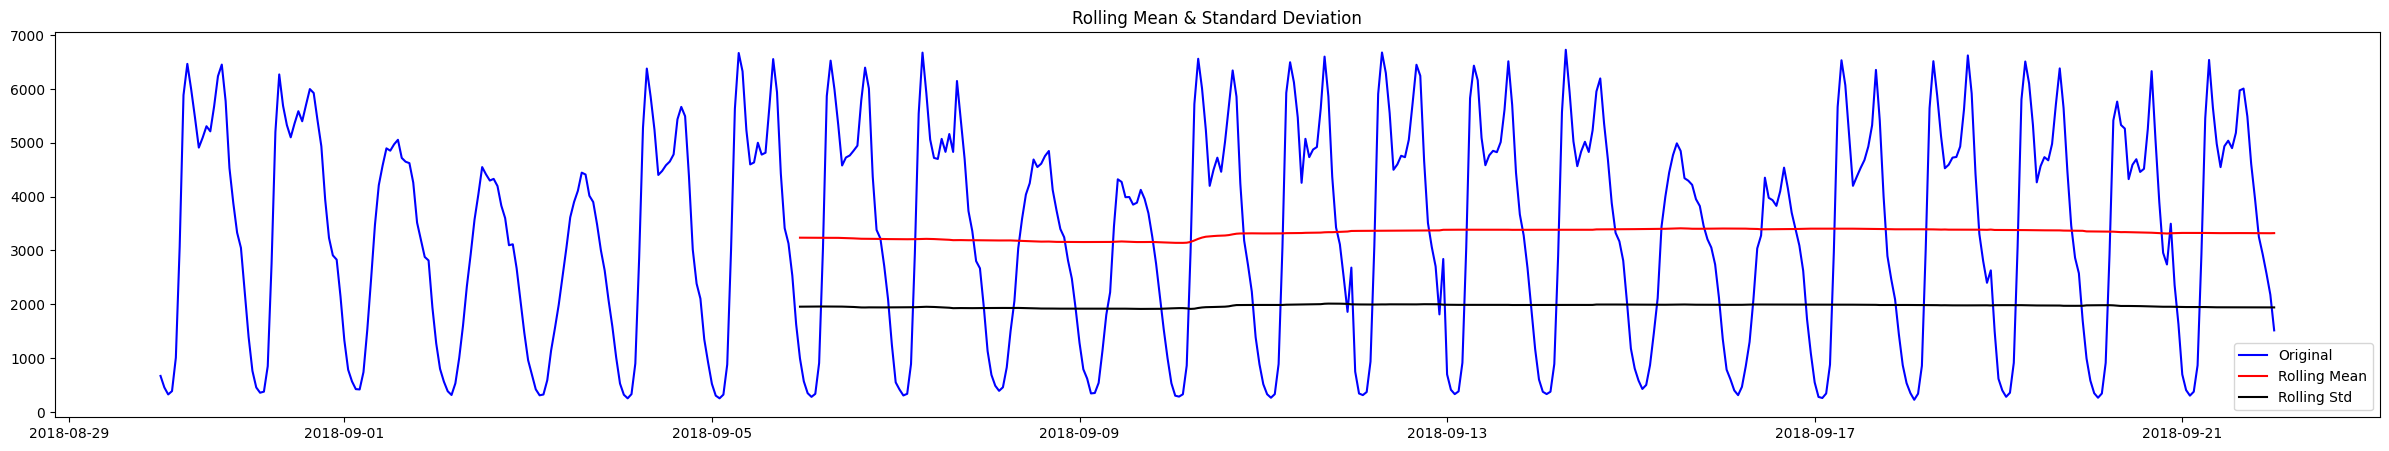

Results of Dickey-Fuller Test:
p-value = 0.0698. The series is likely non-stationary.
Test Statistic                  -2.725073
p-value                          0.069799
#Lags Used                      24.000000
Number of Observations Used    528.000000
Critical Value (1%)             -3.442796
Critical Value (5%)             -2.867030
Critical Value (10%)            -2.569694
dtype: float64


In [14]:
test_stationarity(ts_train.traffic_volume)

In [15]:
# ACF and PACF plots
lag = 24
lag_pacf = pacf(ts_train.traffic_volume, nlags=lag, method='ols')
lag_acf = acf(ts_train.traffic_volume, nlags=lag)

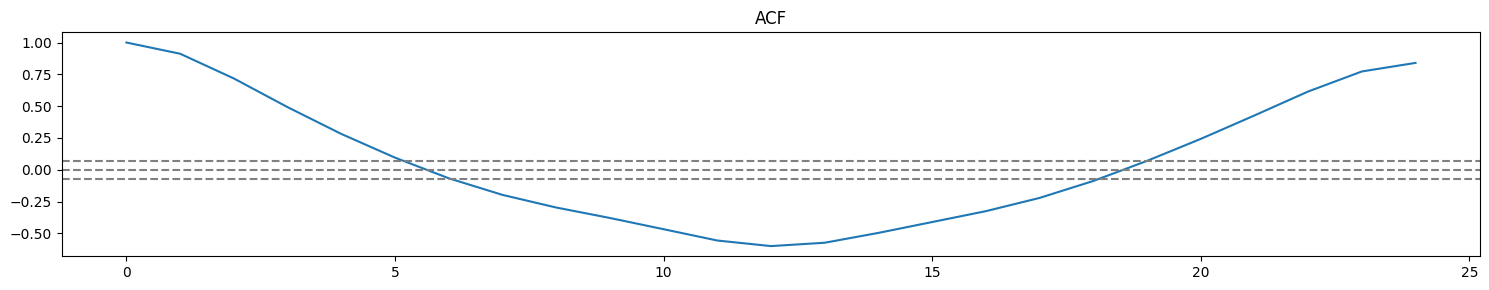

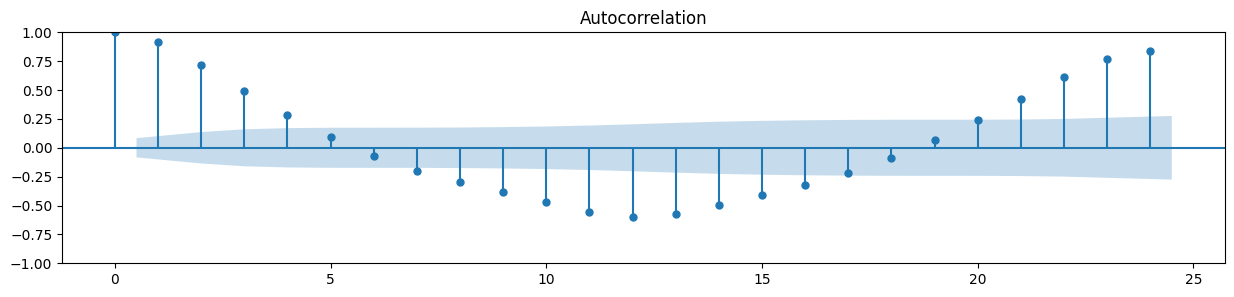

In [16]:
#Plot ACF:
plt.figure(figsize=(15,3))
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('ACF')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,3))
plot_acf(ts_train.traffic_volume, ax=plt.gca(),lags=lag)
plt.show()

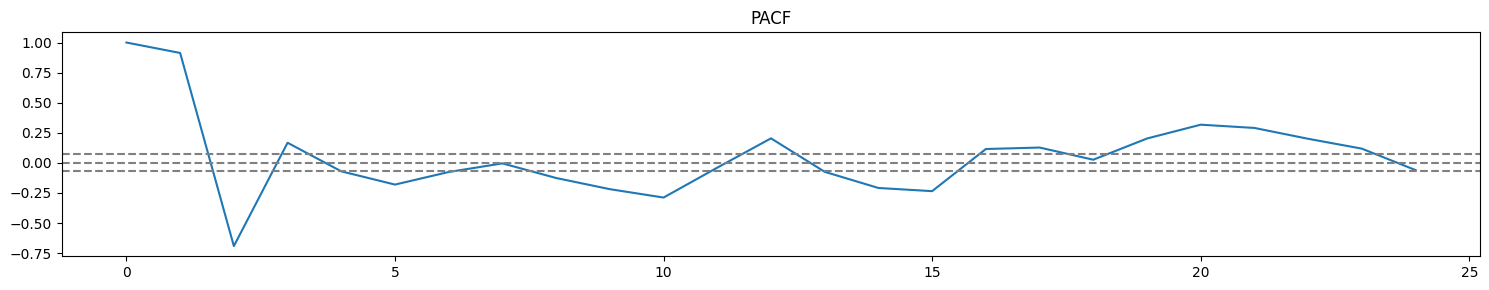

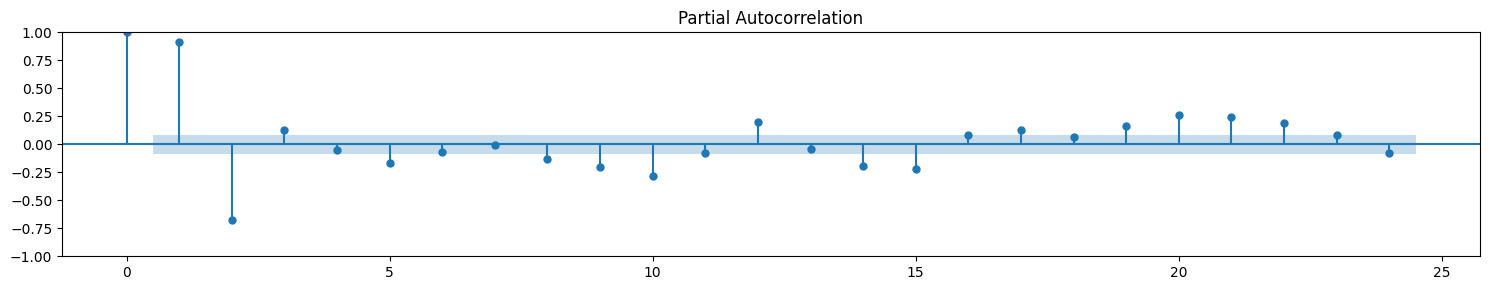

In [17]:
#Plot PACF:
plt.figure(figsize=(15,3))
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('PACF')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,3))
plot_pacf(ts_train.traffic_volume, ax=plt.gca(), lags=lag)
plt.tight_layout()
plt.show()

In [18]:
p=2
d=0
q=1

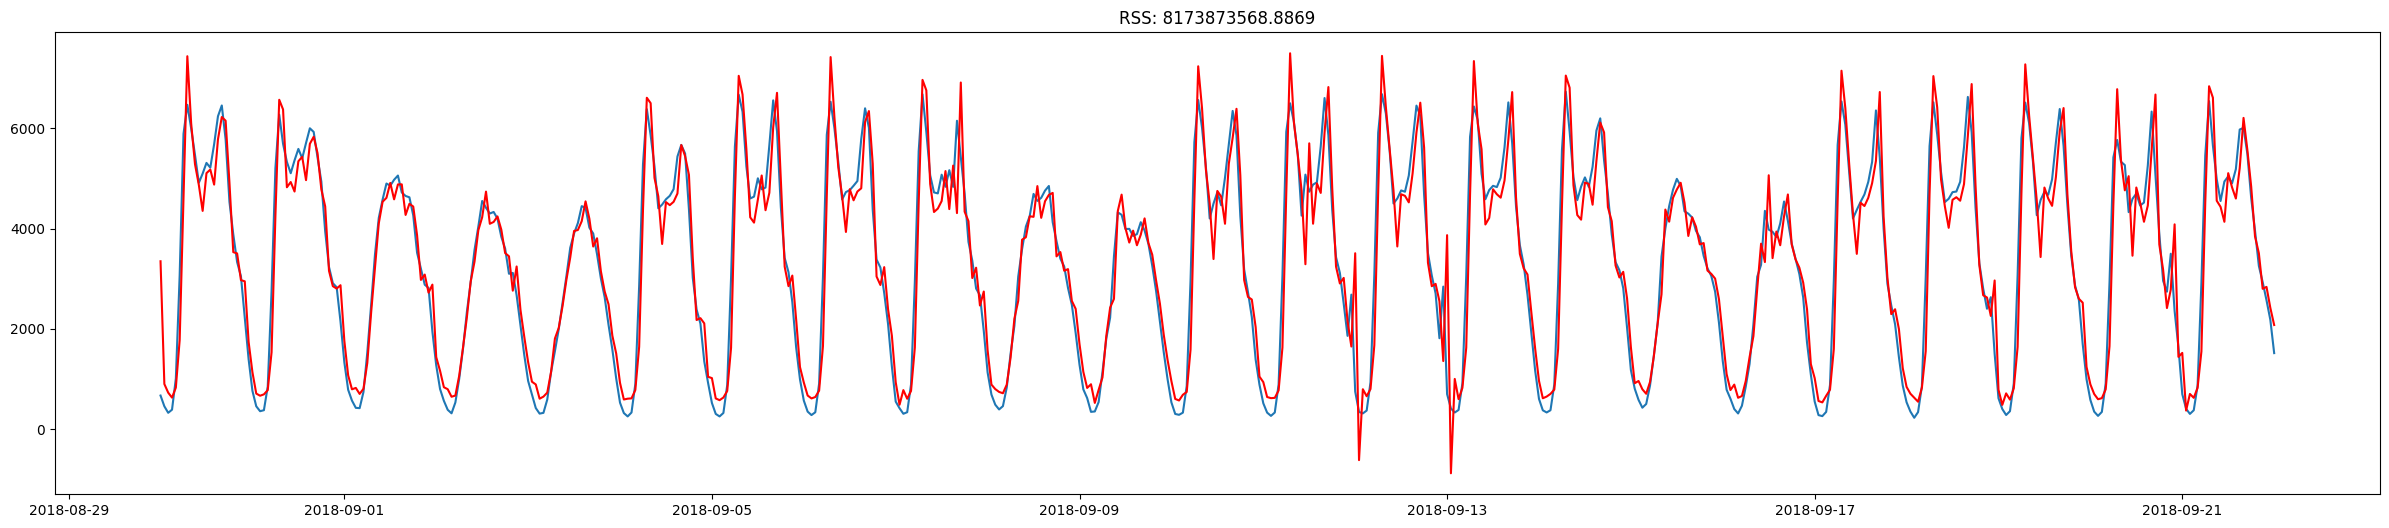

In [23]:
# ARIMA
model = ARIMA(ts_train.traffic_volume, order=(p, d, q))
#model = ARIMA(ts_train, order=(1, 0, 1))
results_ARIMA = model.fit()
plt.figure(figsize=(30,6))
plt.plot(ts_train.traffic_volume)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues).dropna()**2))
plt.show()

In [24]:
results_ARIMA.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         traffic_volume   No. Observations:                  553
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -4294.084
Date:                Mon, 08 Apr 2024   AIC                           8598.169
Time:                        07:26:40   BIC                           8619.746
Sample:                    08-30-2018   HQIC                          8606.599
                         - 09-22-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3346.8915    211.892     15.795      0.000    2931.590    3762.193
ar.L1          1.4305      0.049     29.370      0.000       1.335       1.526
ar.L2         -0.5860      0.048    -12.233      0.000      -0.680      -0.492
ma.L1          0.2318      0.058      3.978      0.000       0.118       0.346
sigma2      3.243e+05   1.48e+04     21.870      0.000    2.95e+05    3.53e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               194.70
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                             0.04
Prob(H) (two-sided):                  0.02   Kurtosis:                         5.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

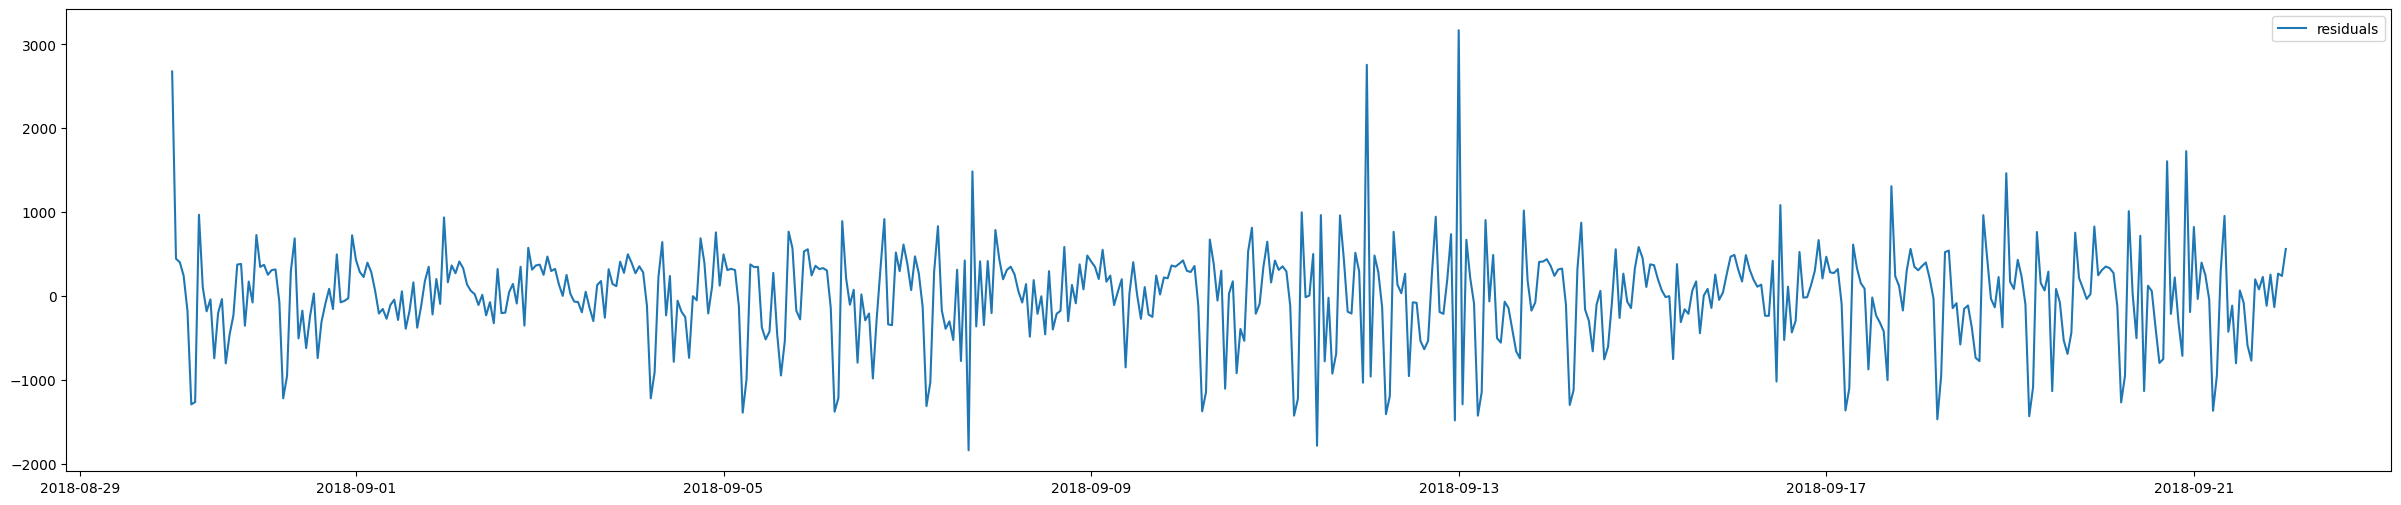

In [25]:
x = pd.DataFrame(results_ARIMA.fittedvalues)
x.columns = ['traffic_volume']
x = x.traffic_volume - ts_train.traffic_volume
plt.figure(figsize=(30,6))
plt.plot(x, label='residuals')
plt.legend(loc='best')
plt.show()


In [29]:
# Test ARIMA on testset
def StartARIMAForecasting(Actual, p, d, q):
    model = ARIMA(Actual, order=(p, d, q))
    model_fit = model.fit()
    prediction = model_fit.forecast()[0]
    return prediction

In [30]:
len(ts_test.traffic_volume)

191

In [31]:
#new arrays to store actual and predictions
Actual = [x for x in ts_train.traffic_volume]
Predictions = list()

#in a for loop, predict values using ARIMA model
for timepoint in range(len(ts_test.traffic_volume)):
    ActualValue =  ts_test.traffic_volume[timepoint]
    #forcast value
    Prediction = StartARIMAForecasting(Actual, p,d,q)
    print('Actual=%f, Predicted=%f' % (ActualValue, Prediction))
    #add it in the list
    Predictions.append(Prediction)
    Actual.append(ActualValue)

predictions=pd.DataFrame(Predictions).set_index(ts_test.index)

Actual=1273.000000, Predicted=1282.372896
Actual=1207.000000, Predicted=1450.499736
Actual=611.000000, Predicted=1443.204571
Actual=647.000000, Predicted=489.347031
Actual=960.000000, Predicted=1118.963535
Actual=1635.000000, Predicted=1471.329721
Actual=2445.000000, Predicted=2328.668300
Actual=3415.000000, Predicted=3081.892807
Actual=3770.000000, Predicted=4046.719971
Actual=4308.000000, Predicted=3845.121492
Actual=4638.000000, Predicted=4577.674490
Actual=4831.000000, Predicted=4642.909437
Actual=4565.000000, Predicted=4755.404154
Actual=4654.000000, Predicted=4174.346288
Actual=4589.000000, Predicted=4611.845541
Actual=4582.000000, Predicted=4352.281955
Actual=4847.000000, Predicted=4438.450094
Actual=4620.000000, Predicted=4864.102060
Actual=4347.000000, Predicted=4234.431775
Actual=3602.000000, Predicted=4058.043502
Actual=2985.000000, Predicted=3020.844720
Actual=2480.000000, Predicted=2669.234939
Actual=1871.000000, Predicted=2272.734624
Actual=1249.000000, Predicted=1647.310

In [32]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [33]:
def error_metrics(y_true, y_pred):
    print('Mean Absolute Error: {:.2f}'.format(mean_absolute_error(y_true, y_pred)))
    print('Root Mean Squared Error: {:.2f}'.format(np.sqrt(mean_squared_error(y_true, y_pred))))
    print('Mean Absolute percentage Error: {:.2f} %'.format(mean_absolute_percentage_error(y_true, y_pred[0])))

In [34]:
#Calculate Model error
error_metrics(ts_test.traffic_volume, predictions)

Mean Absolute Error: 394.42
Root Mean Squared Error: 542.70
Mean Absolute percentage Error: 23.69 %


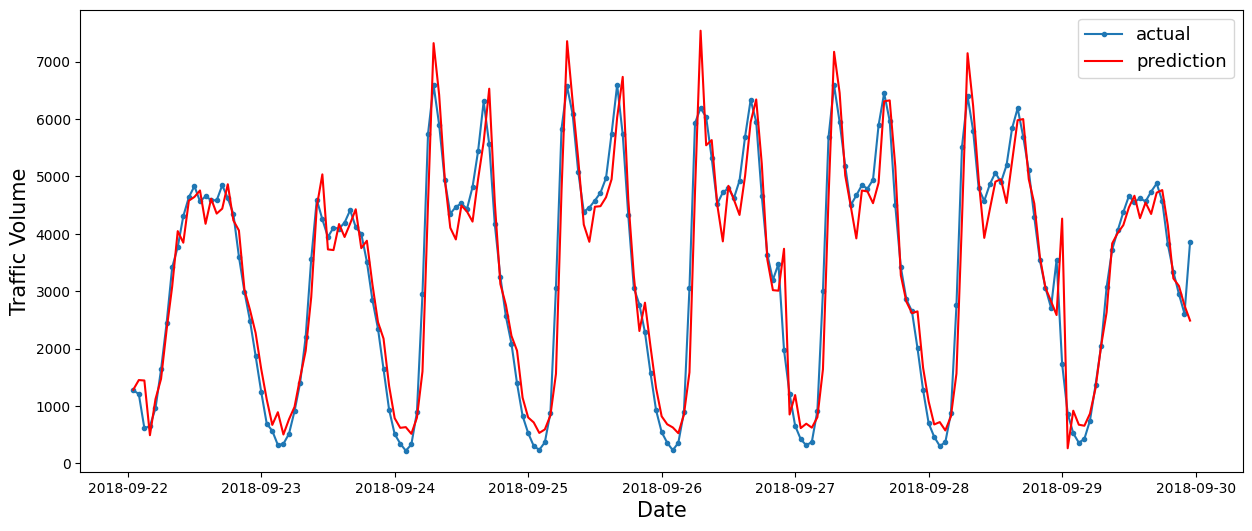

In [35]:
plt.figure(figsize=(15,6))
plt.plot(ts_test.index, pd.DataFrame(ts_test.traffic_volume), marker='.', label="actual")
plt.plot(ts_test.index, pd.DataFrame(Predictions)[0], 'r', label="prediction")
plt.ylabel('Traffic Volume', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=13)
plt.show()

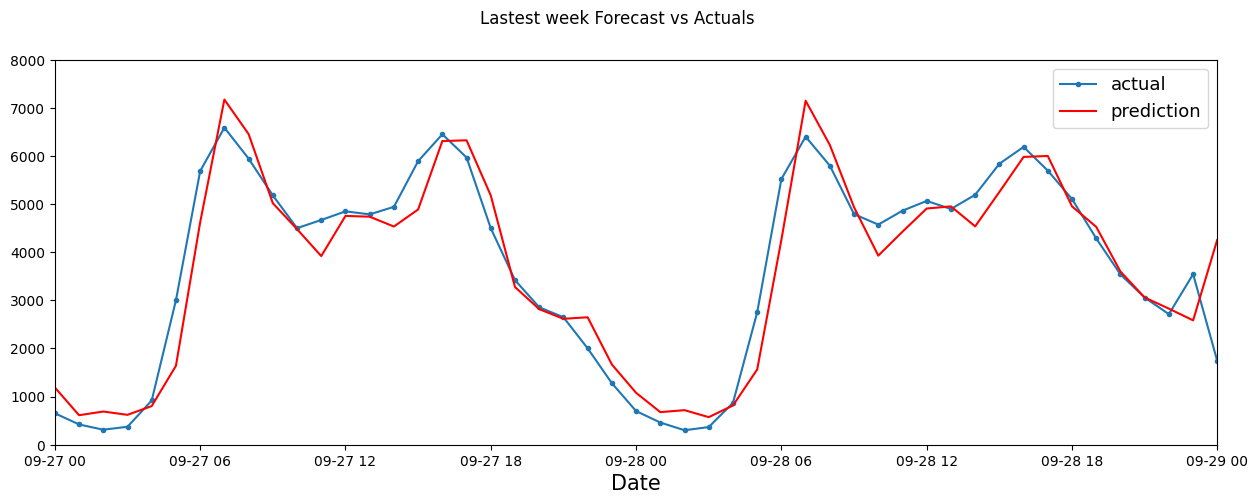

In [36]:
# zoom on lastest 2 days
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
plt.plot(ts_test.index, pd.DataFrame(ts_test.traffic_volume), marker='.', label="actual")
plt.plot(ts_test.index, pd.DataFrame(Predictions)[0], 'r', label="prediction")
ax.set_xbound(lower= datetime.date(2018,9,27), upper=datetime.date(2018,9,29))
plt.legend(fontsize=13)
plt.xlabel('Date', size=15)
ax.set_ylim(0, 8000)
plot = plt.suptitle('Lastest week Forecast vs Actuals')

In [39]:
!pip install pmdarima
### Auto Arima
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(ts_train.traffic_volume, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3,  # maximum p and q
                      max_P=3, max_Q=3,  # maximum p and q
                      m=24,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # Seasonality
                      start_P=0,
                      D=None,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True,
                     n_fits = 50)

print(model.summary())

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.7 MB/s eta 0:00:00
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,1)[24] intercept   : AIC=inf, Time=1.22 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=9963.607, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=8.32 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=8959.811, Time=1.99 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=10712.009, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=9345.111, Time=0.44 sec
 ARIMA(0,0,1)(1,0,1)[24] intercept   : AIC=inf, Time=7.11 sec
 ARIMA(0,0,1)(0,0,2)[24] intercept   : AIC=8837.609, Time=17.69 sec
 ARIMA(0,0,1)(1,0,2)[24] intercept   : AIC=8824.436, Time=22.79 sec
 ARIMA(0,0,1)(2,0,2)[24] intercept   : AIC=inf, Time=36.03 sec
 ARIMA(0,0,1)(1,0,3)[24] intercept   : AIC=8775.105, Time=49.49 sec
 ARIMA(0,0,1)(0,0,3)[24] intercept   : AIC=8782.450, Time=35.98 sec
 ARIMA(0,0,1)(2,0,3)[24] intercept   : AIC=inf, Time=101.26 sec
 ARIMA(0,0,0)(1,0,3)[24]

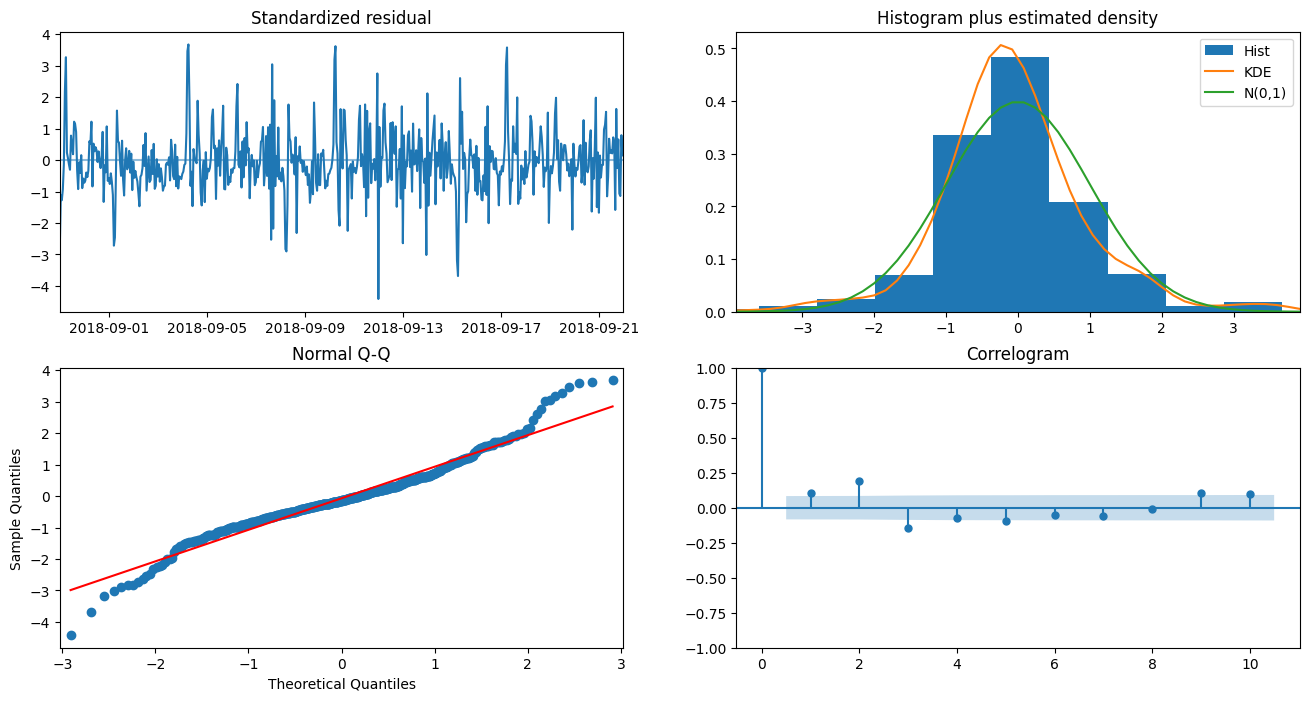

In [40]:
model.plot_diagnostics(figsize=(16,8))
plt.show()

In [41]:
y_pred = model.predict(len(ts_test))
y_pred

2018-09-22 01:00:00    1317.439411
2018-09-22 02:00:00    1198.832204
2018-09-22 03:00:00    1229.213703
2018-09-22 04:00:00    1615.632090
2018-09-22 05:00:00    3270.066107
                          ...     
2018-09-29 19:00:00    4011.647016
2018-09-29 20:00:00    3817.243143
2018-09-29 21:00:00    3761.158857
2018-09-29 22:00:00    3567.847183
2018-09-29 23:00:00    3388.553645
Freq: H, Length: 191, dtype: float64

In [42]:
print('Test Mean Absolute Error:', mean_absolute_error(ts_test.traffic_volume, y_pred))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(ts_test.traffic_volume, y_pred)))
print('Test Mean Absolute percentage Error:',mean_absolute_percentage_error(ts_test.traffic_volume, y_pred))

Test Mean Absolute Error: 1021.1138449583681
Test Root Mean Squared Error: 1337.5298134061136
Test Mean Absolute percentage Error: 114.57639159735228


In [43]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(ts_train.traffic_volume,order=(p,d,q),seasonal_order=(p,d,q, 24))
results=model.fit()

In [44]:
y_pred = pd.DataFrame(results.predict(len(ts_test)))
y_pred

,predicted_mean
2018-09-06 23:00:00,1507.332627
2018-09-07 00:00:00,673.057900
2018-09-07 01:00:00,217.011412
2018-09-07 02:00:00,379.021744
2018-09-07 03:00:00,303.997346
...,...
2018-09-21 20:00:00,3631.824476
2018-09-21 21:00:00,3148.334843
2018-09-21 22:00:00,1929.954031
2018-09-21 23:00:00,2157.043824
